# Model Training (cavity_claw_RouteMeander_eigenmode)

## Configuration

In [1]:
# The parameter file is where the hyperparameters are set. 
# It's reccomended to look at that file first, its interesting and you can set stuff there

from parameters import *

## Library

In [2]:
import os, gc, joblib

# Disable some console warnings so you can be free of them printing. 
# Comment the next two lines if you are a professional and like looking at warnings.
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

os.environ.pop("TF_XLA_FLAGS", None)      # disable XLA 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # show warnings/errors while debugging
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import tensorflow as tf, gc
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

tf.keras.backend.set_floatx("float32") # make the backend use float32 which will be the same as the data--helps speed it up


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model, Model

from pathlib import Path

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd

In [3]:
seed = 0

# Input seed value. If this value is the same, the random number generator 
# will generate the same set of random values every time. We like reproducibility:)
np.random.seed(seed)

# Set the seed value for reproducibility in tensorflow
tf.random.set_seed(seed)

## Check GPU

In [4]:
from tensorflow.python.client import device_lib

# Look at what you are working with. If you dont have a nice GPU I highly reccomend finding one
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10278896956963876842
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40298217472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 891141395771909798
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 4g.40gb, pci bus id: 0000:00:10.0, compute capability: 8.0"
xla_global_id: 416903419
]


I0000 00:00:1768594246.551703  143622 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1768594246.551985  143622 gpu_device.cc:2020] Created device /device:GPU:0 with 38431 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 4g.40gb, pci bus id: 0000:00:10.0, compute capability: 8.0


## Dataset

### Load

In [5]:
# Load all of the nice data you saved from the previous notebook, or downloaded from the drive

if DATA_AUGMENTATION:
    if 'Try Both' not in ENCODING_TYPE:
        encoding = ENCODING_TYPE.replace(' ','_')
        if 'one hot' in ENCODING_TYPE:
            X_train = np.load('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            X_val = np.load('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            X_test = np.load('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

            y_value_train = np.load('{}/npy/y_value_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_val = np.load('{}/npy/y_value_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_test = np.load('{}/npy/y_value_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

            y_exists_train = np.load('{}/npy/y_exists_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_val = np.load('{}/npy/y_exists_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_test = np.load('{}/npy/y_exists_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        elif 'linear' in ENCODING_TYPE:
            X_train = np.load('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            X_val = np.load('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            X_test = np.load('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

            y_value_train = np.load('{}/npy/y_value_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_val = np.load('{}/npy/y_value_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_test = np.load('{}/npy/y_value_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

            y_exists_train = np.load('{}/npy/y_exists_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_val = np.load('{}/npy/y_exists_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_test = np.load('{}/npy/y_exists_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

    elif 'Try Both' in ENCODING_TYPE:
        # one-hot branch
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        y_value_train_one_hot_encoding = np.load('{}/npy/y_value_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_val_one_hot_encoding = np.load('{}/npy/y_value_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_test_one_hot_encoding = np.load('{}/npy/y_value_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        y_exists_train_one_hot_encoding = np.load('{}/npy/y_exists_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_val_one_hot_encoding = np.load('{}/npy/y_exists_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_test_one_hot_encoding = np.load('{}/npy/y_exists_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        # linear branch
        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        y_value_train_linear_encoding = np.load('{}/npy/y_value_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_val_linear_encoding = np.load('{}/npy/y_value_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_test_linear_encoding = np.load('{}/npy/y_value_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        y_exists_train_linear_encoding = np.load('{}/npy/y_exists_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_val_linear_encoding = np.load('{}/npy/y_exists_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_test_linear_encoding = np.load('{}/npy/y_exists_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

else:
    if 'Try Both' not in ENCODING_TYPE:
        if 'one hot' in ENCODING_TYPE:
            X_train = np.load('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            X_val = np.load('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            X_test = np.load('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

            y_value_train = np.load('{}/npy/y_value_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_val = np.load('{}/npy/y_value_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_test = np.load('{}/npy/y_value_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

            y_exists_train = np.load('{}/npy/y_exists_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_val = np.load('{}/npy/y_exists_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_test = np.load('{}/npy/y_exists_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        elif 'linear' in ENCODING_TYPE:
            X_train = np.load('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            X_val = np.load('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            X_test = np.load('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

            y_value_train = np.load('{}/npy/y_value_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_val = np.load('{}/npy/y_value_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_value_test = np.load('{}/npy/y_value_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

            y_exists_train = np.load('{}/npy/y_exists_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_val = np.load('{}/npy/y_exists_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            y_exists_test = np.load('{}/npy/y_exists_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

    elif 'Try Both' in ENCODING_TYPE:
        # one-hot branch
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        y_value_train_one_hot_encoding = np.load('{}/npy/y_value_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_val_one_hot_encoding = np.load('{}/npy/y_value_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_test_one_hot_encoding = np.load('{}/npy/y_value_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        y_exists_train_one_hot_encoding = np.load('{}/npy/y_exists_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_val_one_hot_encoding = np.load('{}/npy/y_exists_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_test_one_hot_encoding = np.load('{}/npy/y_exists_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        # linear branch
        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        y_value_train_linear_encoding = np.load('{}/npy/y_value_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_val_linear_encoding = np.load('{}/npy/y_value_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_value_test_linear_encoding = np.load('{}/npy/y_value_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        y_exists_train_linear_encoding = np.load('{}/npy/y_exists_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_val_linear_encoding = np.load('{}/npy/y_exists_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_exists_test_linear_encoding = np.load('{}/npy/y_exists_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)


### Visualize

In [6]:
# Look at the shapes of training and test sets in case you want to orient yourself

if 'Try Both' not in ENCODING_TYPE:
    print('X_train.shape:', X_train.shape)
    print('X_val.shape:', X_val.shape)
    print('y_value_train.shape:', y_value_train.shape)
    print('y_value_val.shape:', y_value_val.shape)
    print('y_exists_train.shape:', y_exists_train.shape)
    print('y_exists_val.shape:', y_exists_val.shape)
    print('y_value_train[0]:', y_value_train[0])
    print('y_exists_train[0]:', y_exists_train[0])
    print('y_exists_val[0]:', y_exists_val[0])

else:
    print('X_train_linear_encoding.shape:', X_train_linear_encoding.shape)
    print('X_val_linear_encoding.shape:', X_val_linear_encoding.shape)
    print('y_value_train_linear_encoding.shape:', y_value_train_linear_encoding.shape)
    print('y_value_val_linear_encoding.shape:', y_value_val_linear_encoding.shape)
    print('y_exists_train_linear_encoding.shape:', y_exists_train_linear_encoding.shape)
    print('y_exists_val_linear_encoding.shape:', y_exists_val_linear_encoding.shape)
    print('y_value_train_linear_encoding[0]:', y_value_train_linear_encoding[0])
    print('y_exists_train_linear_encoding[0]:', y_exists_train_linear_encoding[0])

    print('X_train_one_hot_encoding.shape:', X_train_one_hot_encoding.shape)
    print('X_val_one_hot_encoding.shape:', X_val_one_hot_encoding.shape)
    print('y_value_train_one_hot_encoding.shape:', y_value_train_one_hot_encoding.shape)
    print('y_value_val_one_hot_encoding.shape:', y_value_val_one_hot_encoding.shape)
    print('y_exists_train_one_hot_encoding.shape:', y_exists_train_one_hot_encoding.shape)
    print('y_exists_val_one_hot_encoding.shape:', y_exists_val_one_hot_encoding.shape)
    print('y_value_train_one_hot_encoding[0]:', y_value_train_one_hot_encoding[0])
    print('y_exists_train_one_hot_encoding[0]:', y_exists_train_one_hot_encoding[0])

X_train.shape: (851, 2)
X_val.shape: (182, 2)
y_value_train.shape: (851, 16)
y_value_val.shape: (182, 16)
y_exists_train.shape: (851, 16)
y_exists_val.shape: (182, 16)
y_value_train[0]: [0.1773399  0.         0.         1.         1.         1.
 0.35714286 1.         0.65217391 0.         0.5        0.
 0.         1.         1.         0.        ]
y_exists_train[0]: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
y_exists_val[0]: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [7]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train) #can check this in previous script as well after loading to make sure it matches
else:
    display(X_train_one_hot_encoding)
    display(X_train_linear_encoding)

array([[0.33514963, 0.00078676],
       [0.01809174, 0.15265725],
       [0.01032841, 0.14763822],
       ...,
       [0.05754841, 0.25609945],
       [0.57781303, 0.0013409 ],
       [0.06168676, 0.26742149]])

In [8]:
# Look at how it was split and decide if you like the split

if 'Try Both' not in ENCODING_TYPE:
    total = len(X_train) + len(X_test) + len(X_val)
    print('---------------------------------------')
    print('Train set shape x:                {}, {:.2f}%'.format(len(X_train), (len(X_train) * 100.) / total))
    print('Validation set shape x:           {}, {:.2f}%'.format(len(X_val), (len(X_val) * 100.) / total))
    print('Test set shape x:                 {}, {:.2f}%'.format(len(X_test), (len(X_test) * 100.) / total))
    print('---------------------------------------')

    total = len(y_value_train) + len(y_value_test) + len(y_value_val)
    print('---------------------------------------')
    print('Train set shape y_value:          {}, {:.2f}%'.format(len(y_value_train), (len(y_value_train) * 100.) / total))
    print('Validation set shape y_value:     {}, {:.2f}%'.format(len(y_value_val), (len(y_value_val) * 100.) / total))
    print('Test set shape y_value:           {}, {:.2f}%'.format(len(y_value_test), (len(y_value_test) * 100.) / total))
    print('---------------------------------------')

else:
    total = len(X_train_one_hot_encoding) + len(X_test_one_hot_encoding) + len(X_val_one_hot_encoding)
    print('---------------------------------------')
    print('Train set shape x one_hot_encoding:      {}, {:.2f}%'.format(len(X_train_one_hot_encoding), (len(X_train_one_hot_encoding) * 100.) / total))
    print('Validation set shape x one_hot_encoding: {}, {:.2f}%'.format(len(X_val_one_hot_encoding), (len(X_val_one_hot_encoding) * 100.) / total))
    print('Test set shape x one_hot_encoding:       {}, {:.2f}%'.format(len(X_test_one_hot_encoding), (len(X_test_one_hot_encoding) * 100.) / total))
    print('---------------------------------------')

    total = len(y_value_train_one_hot_encoding) + len(y_value_test_one_hot_encoding) + len(y_value_val_one_hot_encoding)
    print('---------------------------------------')
    print('Train set shape y_value one_hot_encoding:      {}, {:.2f}%'.format(len(y_value_train_one_hot_encoding), (len(y_value_train_one_hot_encoding) * 100.) / total))
    print('Validation set shape y_value one_hot_encoding: {}, {:.2f}%'.format(len(y_value_val_one_hot_encoding), (len(y_value_val_one_hot_encoding) * 100.) / total))
    print('Test set shape y_value one_hot_encoding:       {}, {:.2f}%'.format(len(y_value_test_one_hot_encoding), (len(y_value_test_one_hot_encoding) * 100.) / total))

    total = len(X_train_linear_encoding) + len(X_test_linear_encoding) + len(X_val_linear_encoding)
    print('---------------------------------------')
    print('Train set shape x linear_encoding:      {}, {:.2f}%'.format(len(X_train_linear_encoding), (len(X_train_linear_encoding) * 100.) / total))
    print('Validation set shape x linear_encoding: {}, {:.2f}%'.format(len(X_val_linear_encoding), (len(X_val_linear_encoding) * 100.) / total))
    print('Test set shape x linear_encoding:       {}, {:.2f}%'.format(len(X_test_linear_encoding), (len(X_test_linear_encoding) * 100.) / total))
    print('---------------------------------------')

    total = len(y_value_train_linear_encoding) + len(y_value_test_linear_encoding) + len(y_value_val_linear_encoding)
    print('---------------------------------------')
    print('Train set shape y_value linear_encoding:      {}, {:.2f}%'.format(len(y_value_train_linear_encoding), (len(y_value_train_linear_encoding) * 100.) / total))
    print('Validation set shape y_value linear_encoding: {}, {:.2f}%'.format(len(y_value_val_linear_encoding), (len(y_value_val_linear_encoding) * 100.) / total))
    print('Test set shape y_value linear_encoding:       {}, {:.2f}%'.format(len(y_value_test_linear_encoding), (len(y_value_test_linear_encoding) * 100.) / total))

---------------------------------------
Train set shape x:                851, 69.98%
Validation set shape x:           182, 14.97%
Test set shape x:                 183, 15.05%
---------------------------------------
---------------------------------------
Train set shape y_value:          851, 69.98%
Validation set shape y_value:     182, 14.97%
Test set shape y_value:           183, 15.05%
---------------------------------------


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

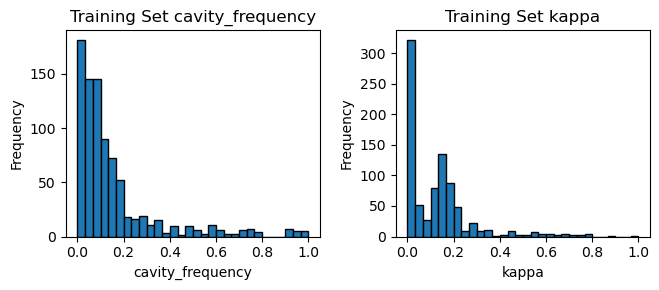

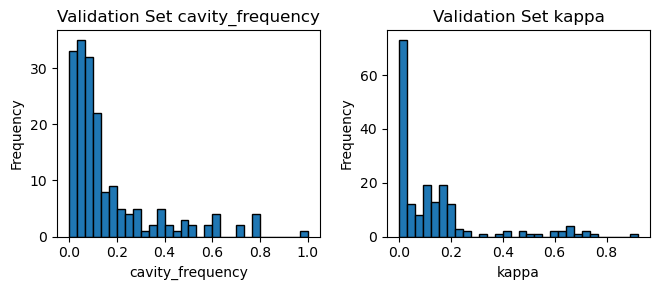

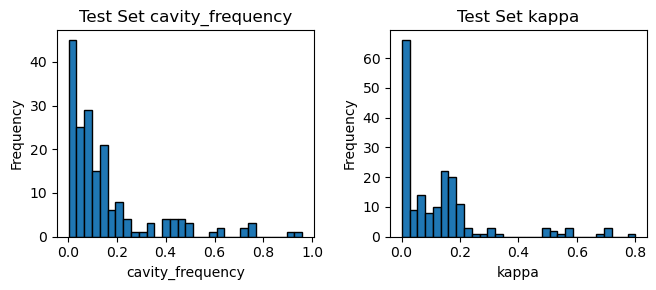

In [10]:
# Bin the data and look at how its distributed, probably the more random/spread out the better 
# for training, but this will improve as the database fills out

if 'Try Both' not in ENCODING_TYPE:
    #--------------------Training Set---------------------
    save_encoding = ENCODING_TYPE.replace(' ','_')
    
    num_cols = X_train.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_train[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Training Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/training_set_data_distribution{save_encoding}.pdf')
    plt.show()

    #--------------------Validation Set---------------------
    num_cols = X_val.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_val[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Validation Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/validation_set_data_distribution{save_encoding}.pdf')
    plt.show()
    
    #--------------------Test Set---------------------
    num_cols = X_test.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_test[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Test Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/test_set_data_distribution{save_encoding}.pdf')
    plt.show()
    
else: #just plot linear encoding for now to not get plot overwhelm
    #--------------------Training Set---------------------
    num_cols = X_train_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_train_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Training Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/training_set_data_distribution_linear_encoding.pdf')
    plt.show()

    #--------------------Validation Set---------------------
    num_cols = X_val_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_val_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Validation Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/validation_set_data_distribution_linear_encoding.pdf')
    plt.show()
    
    
    #--------------------Test Set---------------------
    num_cols = X_test_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    for i in range(num_cols):
        axes[i].hist(X_test_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Test Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/test_set_data_distribution_linear_encoding.pdf')
    plt.show()

In [11]:
steps_per_epoch = int(np.ceil(len(X_train) / TRAIN_BATCH_SIZE))
LR_DECAY_STEPS = steps_per_epoch * 20   # decay every ~10 epochs

## MLP

### Create model

Create a classical multi-layer perceptron for regression. Taking some inspiration from [Deep learning-based I-V Global Parameter Extraction for BSIM-CMG](https://www.sciencedirect.com/science/article/pii/S003811012300179X), Solid-State Electronics, Vol. 209, November 2023.

The above publication predicted parameters for BSIM, which is a physics model for advanced transistors that is complicated and might be a similar complexity to the physics we are trying to target/map with these SC qubit hamiltonian values

Reccomended to download a third party app like "Sleep control Center" or "Amphetamine" to prevent computer from sleeping during the many hour/day long training process

In [12]:
def elementwise_value_loss(loss_name):
    name = str(loss_name).lower()

    if name in ["mse", "mean_squared_error", "mean square error"]:
        def _loss(y_true, y_pred):
            y_true = tf.cast(y_true, y_pred.dtype)
            return tf.math.squared_difference(y_true, y_pred)  # (N,D)
        return _loss

    if name in ["mae", "mean_absolute_error", "mean absolute error"]:
        def _loss(y_true, y_pred):
            y_true = tf.cast(y_true, y_pred.dtype)
            return tf.abs(y_true - y_pred)  # (N,D)
        return _loss

    print(f"[WARN] TRAIN_LOSS='{loss_name}' not recognized; defaulting to elementwise MSE.")
    def _loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.math.squared_difference(y_true, y_pred)
    return _loss


VALUE_LOSS_FN = elementwise_value_loss(TRAIN_LOSS)


### Create Model by Hand

In [13]:
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    # n output neurons for n parameters (value and exists heads both use this size)
    if 'Try Both' not in ENCODING_TYPE:
        # Multilayer perceptron (MLP)
        model_shape = f'mlp_{len(X_test[0])}_'
        # inner layer sizes
        model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)
        print(len(y_value_train[0]))
        model_shape += f'_{len(y_value_train[0])}'
    else:
        # Multilayer perceptron (MLP) for both encodings
        model_shape_one_hot_encoding = f'mlp_{len(X_test_one_hot_encoding[0])}_'
        model_shape_linear_encoding = f'mlp_{len(X_test_linear_encoding[0])}_'
        model_shape_one_hot_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
        model_shape_linear_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)

        print('one hot:', len(y_value_train_one_hot_encoding[0]))
        model_shape_one_hot_encoding += f'_{len(y_value_train_one_hot_encoding[0])}'
        print('linear:', len(y_value_train_linear_encoding[0]))
        model_shape_linear_encoding += f'_{len(y_value_train_linear_encoding[0])}'


In [14]:
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    if 'Try Both' not in ENCODING_TYPE:
        #initialize a model, which lets us build a stack of layers
        inputs = Input(shape=(len(X_test[0]),), name='input1')
        x = inputs

        #iterate over the configuration of neurons for each hidden layer specified in NEURONS_PER_LAYER
        for i, n in enumerate(NEURONS_PER_LAYER):
            # add a fully connected (dense) hidden layer with specified number of neurons
            # the LeCun uniform initializer is used when initializing weights, this makes the model more stable
            # l2 regularization is used in each layer to penalizing large weights, which prevents overfitting
            x = Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

            # apply a Leaky ReLU activation function to the outputs of the dense layer
            # this introduces non-linearities, allowing the network to learn complex functions
            #leaky ReLU is chosen over standard ReLU to help mitigate the "dying ReLU" problem:
            #     - this problem is when neurons using the ReLU activation function output zero for all inputs and stop learning
            #     - can be mitigated by using variations like Leaky ReLU or proper initialization
            x = LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i))(x)
            
            # add a dropout layer to reduce overfitting -- randomly drops a set fraction (like 30%) of outputs from the layer
            x = Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i))(x)
        
        # add the output layers consisting of # neurons, corresponding to the # target variables we aim to predict.
        # value_out predicts the numerical parameter values; exists_out predicts if each parameter is defined (0/1).
        value_out = Dense(len(y_value_train[0]), activation='linear', name='value_out', kernel_initializer='lecun_uniform')(x)
        exists_out = Dense(len(y_value_train[0]), activation='sigmoid', name='exists_out', kernel_initializer='lecun_uniform')(x)

        model = tf.keras.Model(
            inputs=inputs,
            outputs={'value_out': value_out, 'exists_out': exists_out},
            name='mlp_multi_output'
        )

    
    else:
        # One-hot encoding model
        inputs_one_hot = Input(shape=(len(X_test_one_hot_encoding[0]),), name='input1')
        x_oh = inputs_one_hot
        for i, n in enumerate(NEURONS_PER_LAYER):
            x_oh = Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_oh)
            x_oh = LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i))(x_oh)
            x_oh = Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i))(x_oh)
        value_out_oh = Dense(len(y_value_train_one_hot_encoding[0]), activation='linear', name='value_out', kernel_initializer='lecun_uniform')(x_oh)
        exists_out_oh = Dense(len(y_value_train_one_hot_encoding[0]), activation='sigmoid', name='exists_out', kernel_initializer='lecun_uniform')(x_oh)
        model_one_hot_encoding = tf.keras.Model(
            inputs=inputs_one_hot,
            outputs={'value_out': value_out_oh, 'exists_out': exists_out_oh},
            name='mlp_multi_output_one_hot'
        )

        # Linear encoding model
        inputs_lin = Input(shape=(len(X_test_linear_encoding[0]),), name='input1')
        x_lin = inputs_lin
        for i, n in enumerate(NEURONS_PER_LAYER):
            x_lin = Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_lin)
            x_lin = LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i))(x_lin)
            x_lin = Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i))(x_lin)
        value_out_lin = Dense(len(y_value_train_linear_encoding[0]), activation='linear', name='value_out', kernel_initializer='lecun_uniform')(x_lin)
        exists_out_lin = Dense(len(y_value_train_linear_encoding[0]), activation='sigmoid', name='exists_out', kernel_initializer='lecun_uniform')(x_lin)
        model_linear_encoding = tf.keras.Model(
            inputs=inputs_lin,
            outputs={'value_out': value_out_lin, 'exists_out': exists_out_lin},
            name='mlp_multi_output_linear'
        )


In [15]:
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    # The exponential decay learning rate schedule gradually reduces the learning rate, fine-tuning the learning process for better convergence
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LR_INITIAL,
        decay_steps=LR_DECAY_STEPS,
        decay_rate=LR_DECAY_RATE,
        staircase=LR_STAIRCASE
    )
    
    if 'Try Both' not in ENCODING_TYPE:
        # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
        )
    else:
        # Linear encoding model
        model_linear_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
        )
        # One-hot encoding model
        model_one_hot_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
        )


In [16]:
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    !mkdir -p model
    if 'Try Both' not in ENCODING_TYPE:
        best_model_file = 'model/{}_best_model.keras'.format(model_shape)
        last_model_file = 'model/{}_last_model.keras'.format(model_shape)
    else:
        best_model_file_one_hot_encoding = 'model/{}_best_model_one_hot_encoding.keras'.format(model_shape_one_hot_encoding)
        last_model_file_one_hot_encoding = 'model/{}_last_model_one_hot_encoding.keras'.format(model_shape_one_hot_encoding)
    
        best_model_file_linear_encoding = 'model/{}_best_model_linear_encoding.keras'.format(model_shape_linear_encoding)
        last_model_file_linear_encoding = 'model/{}_last_model_linear_encoding.keras'.format(model_shape_linear_encoding)

Enable training (`train_and_save`) to overwrite the model file.

In [17]:
train_and_save = True

We use Adam optimizer, minimize the Mean Squared Logarithmic Error, and early stop.

#### Training

In [18]:
from IPython.display import clear_output
# Set up monitors and plots for later tracking purposes

if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    class TrainingPlot(tf.keras.callbacks.Callback):
         
        # This function is called when the training begins
        def on_train_begin(self, logs={}):
            # Initialize the lists for holding the logs, losses 
            self.losses = []
            self.val_losses = []
            self.logs = []
        
        # This function is called at the end of each epoch
        def on_epoch_end(self, epoch, logs={}):
            
            # Append the logs, losses  to the lists
            self.logs.append(logs)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            
            # Before plotting ensure at least 2 epochs have passed
            if len(self.losses) > 1:
                
                # Clear the previous plot
                clear_output(wait=True)
                N = np.arange(0, len(self.losses))
                
                # Plot train loss, train acc, val loss and val acc against epochs passed
                plt.figure()
                plt.plot(N, self.losses, label = "train_loss")
                plt.plot(N, self.val_losses, label = "val_loss")
                plt.title("Training Loss [Epoch {}]".format(epoch))
                plt.xlabel("Epoch #")
                plt.ylabel("Loss/Accuracy")
                plt.legend()
                plt.show()
           

class LearningRateMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    #we have to do some checking for versions here or else we will get an Adam error when using this monitor
    def _current_lr(self, optimizer):
        # look and see if you get "lr" ir "learning_rate" depending on the version
        lr = getattr(optimizer, "lr", None) or getattr(optimizer, "learning_rate", None)

        # if this is a shecdule then evaluate it at current iteration step
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            return float(lr(optimizer.iterations).numpy())

        # if not a schedule, its a scalar/variable/tensor
        return float(tf.keras.backend.get_value(lr))

    def on_epoch_end(self, epoch, logs=None):
        try:
            lr_val = self._current_lr(self.model.optimizer)
        except Exception:
            # for anything else fallback
            lr_val = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.learning_rates.append(lr_val)


In [19]:
%%time

# Train the model
history = None  
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    if train_and_save: 
        # Set up early stopping to prevent overfitting by halting training when validation loss stops improving
        early_stopping = EarlyStopping(
            monitor='val_value_out_loss',                      # Monitor validation loss for stopping criteria 
            mode='min',                              # Stop when the monitored quantity has stopped decreasing
            patience=TRAIN_EARLY_STOPPING_PATIENCE,  # Number of epochs to wait after last improvement
            verbose=1                                # Enable logging when early stopping happens
        )
    
        # Train the model on the training data and validate on a portion of it
        if 'Try Both' not in ENCODING_TYPE:
            plot_callback = TrainingPlot()      # Plot training progress
            lr_monitor = LearningRateMonitor()  # Watch learning rate changes
            
            # sample weights: use exists mask for value_out, ones for exists_out
            value_sample_weight_train = np.asarray(y_exists_train)
            value_sample_weight_val = np.asarray(y_exists_val)  # not used directly but handy to keep
            exists_sample_weight_train = np.ones_like(value_sample_weight_train)
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint = ModelCheckpoint(
                filepath=best_model_file,          
                monitor='val_value_out_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
   
            history = model.fit(
            np.asarray(X_train),
            {
                "value_out": np.asarray(y_value_train),
                "exists_out": np.asarray(y_exists_train),
            },
            sample_weight={
                "value_out": np.asarray(y_exists_train).astype("float32"),  # (N,) OR (N,16) depending on your value loss setup
                "exists_out": np.ones((len(y_exists_train),), dtype="float32"),  # <-- MUST be (N,)
            },
            validation_data=(
                np.asarray(X_val),
                {
                    "value_out": np.asarray(y_value_val),
                    "exists_out": np.asarray(y_exists_val),
                },
                {
                    "value_out": np.asarray(y_exists_val).astype("float32"),
                    "exists_out": np.ones((len(y_exists_val),), dtype="float32"),  # <-- MUST be (N,)
                },
            ),
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            callbacks=[early_stopping, model_checkpoint, plot_callback, lr_monitor],
            verbose=1,
        )
                    


            
            model.save(last_model_file)  # Save the final model when done training!
        
        else:
            #-----------------------------------------linear--------------------------------------------
            plot_callback_linear_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_linear_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            value_sample_weight_train_linear = np.asarray(y_exists_train_linear_encoding)
            value_sample_weight_val_linear = np.asarray(y_exists_val_linear_encoding)
            exists_sample_weight_train_linear = np.ones_like(value_sample_weight_train_linear)
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_linear_encoding = ModelCheckpoint(
                filepath=best_model_file_linear_encoding,          
                monitor='val_value_out_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_linear_encoding = model_linear_encoding.fit(
                np.asarray(X_train_linear_encoding),
                [
                    np.asarray(y_value_train_linear_encoding),
                    np.asarray(y_exists_train_linear_encoding)
                ],
                epochs=EPOCHS,
                batch_size=TRAIN_BATCH_SIZE,
                validation_data=(
                    np.asarray(X_val_linear_encoding),
                    [
                        np.asarray(y_value_val_linear_encoding),
                        np.asarray(y_exists_val_linear_encoding),
                    ],
                    [
                        np.asarray(y_exists_val_linear_encoding).astype("float32"),   # (N,16) mask for value_out
                        np.ones((len(y_exists_val_linear_encoding),), dtype="float32")# (N,) weights for exists_out
                    ],
                ),

                sample_weight=[
                    np.asarray(y_exists_train_linear_encoding).astype("float32"),              # (N,16) mask for value_out
                    np.ones((len(y_exists_train_linear_encoding),), dtype="float32"),          # (N,)   weights for exists_out
                ]

                ,
                callbacks=[early_stopping, model_checkpoint_linear_encoding, plot_callback_linear_encoding, lr_monitor_linear_encoding],
                verbose=1
            )


            
            model_linear_encoding.save(last_model_file_linear_encoding)  # Save the final model when done training!
            
            #-----------------------------------------one hot--------------------------------------------
            plot_callback_one_hot_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_one_hot_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            value_sample_weight_train_oh = np.asarray(y_exists_train_one_hot_encoding)
            value_sample_weight_val_oh = np.asarray(y_exists_val_one_hot_encoding)
            exists_sample_weight_train_oh = np.ones_like(value_sample_weight_train_oh)
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_one_hot_encoding = ModelCheckpoint(
                filepath=best_model_file_one_hot_encoding,          
                monitor='val_value_out_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_one_hot_encoding = model_one_hot_encoding.fit(
                np.asarray(X_train_one_hot_encoding),
                {
                    'value_out': np.asarray(y_value_train_one_hot_encoding),
                    'exists_out': np.asarray(y_exists_train_one_hot_encoding)
                },
                sample_weight={
                    "value_out": np.asarray(y_exists_train_one_hot_encoding).astype("float32"),   # (N,16)
                    "exists_out": np.ones((len(y_exists_train_one_hot_encoding),), dtype="float32"),
                },
                validation_data=(
                    np.asarray(X_val_one_hot_encoding),
                    {
                        'value_out': np.asarray(y_value_val_one_hot_encoding),
                        'exists_out': np.asarray(y_exists_val_one_hot_encoding)
                    },
                    {
                        "value_out": np.asarray(y_exists_val_one_hot_encoding).astype("float32"), # (N,16)
                        "exists_out": np.ones((len(y_exists_val_one_hot_encoding),), dtype="float32"),
                    }
                ),
                epochs=EPOCHS,
                batch_size=TRAIN_BATCH_SIZE,
                callbacks=[early_stopping, model_checkpoint_one_hot_encoding, plot_callback_one_hot_encoding, lr_monitor_one_hot_encoding],
                verbose=1
            )




            
            model_one_hot_encoding.save(last_model_file_one_hot_encoding)  # Save the final model when done training!


CPU times: user 17 μs, sys: 2 μs, total: 19 μs
Wall time: 26.9 μs


Load the saved best model and use it from now on.

In [20]:
from keras.saving import load_model

if not KERAS_TUNER and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    if 'Try Both' not in ENCODING_TYPE:
        model = load_model(best_model_file, compile=False)
        model.compile(
            optimizer=model.optimizer if hasattr(model, "optimizer") else "adam",
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']},
        )
    else:
        model_one_hot_encoding = load_model(best_model_file_one_hot_encoding, compile=False)
        model_one_hot_encoding.compile(
            optimizer=model_one_hot_encoding.optimizer if hasattr(model_one_hot_encoding, "optimizer") else "adam",
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']},
        )

        model_linear_encoding = load_model(best_model_file_linear_encoding, compile=False)
        model_linear_encoding.compile(
            optimizer=model_linear_encoding.optimizer if hasattr(model_linear_encoding, "optimizer") else "adam",
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0},
            metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']},
        )


### Sweep total number of parameters to find the right range

In [21]:
if SWEEP_PARAM_NUM:
    
    def build_masked_mlp(neurons_per_layer, input_dim, output_dim):
        x_in = Input(shape=(input_dim,), name="input1")
        x = x_in

        for i, n in enumerate(neurons_per_layer):
            x = Dense(
                n,
                name=f"fc{i}",
                kernel_initializer="lecun_uniform",
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
            )(x)
            x = LeakyReLU(negative_slope=0.01, name=f"leaky_relu{i}")(x)
            x = Dropout(rate=TRAIN_DROPOUT_RATE, name=f"dropout{i}")(x)

        value_out = Dense(
            output_dim,
            activation="linear",
            name="value_out",
            kernel_initializer="lecun_uniform",
            dtype="float32",
        )(x)

        exists_out = Dense(
            output_dim,
            activation="sigmoid",
            name="exists_out",
            kernel_initializer="lecun_uniform",
            dtype="float32",
        )(x)

        return Model(inputs=x_in, outputs={"value_out": value_out, "exists_out": exists_out})

    def make_optimizer():
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=LR_INITIAL,
            decay_steps=LR_DECAY_STEPS,
            decay_rate=LR_DECAY_RATE,
            staircase=LR_STAIRCASE
        )
        return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    def train_one_config(neurons_per_layer, seed=0):
        tf.keras.backend.clear_session()
        tf.random.set_seed(seed)
        np.random.seed(seed)

        model = build_masked_mlp(
            neurons_per_layer=neurons_per_layer,
            input_dim=X_train.shape[1],
            output_dim=y_value_train.shape[1],
        )

        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # returns (batch,)
        
        def elementwise_mae(y_true, y_pred):
            # returns (batch, output_dim) so your (batch, output_dim) mask works correctly
            return tf.abs(y_true - y_pred)
        
        model.compile(
            optimizer=make_optimizer(),
            loss={
                "value_out": elementwise_mae,
                "exists_out": bce,
            },
            metrics={
                "value_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
                "exists_out": [tf.keras.metrics.BinaryAccuracy(name="bin_acc")],
            },
            # If your Keras supports it, this helps avoid XLA weirdness:
            jit_compile=False,
        )


        early_stopping = EarlyStopping(
            monitor= 'val_value_out_loss', 
            mode="min",
            patience=TRAIN_EARLY_STOPPING_PATIENCE,
            verbose=0,
            restore_best_weights=True,
        )

        Xtr = np.asarray(X_train)
        Xva = np.asarray(X_val)

        yv_tr = np.asarray(y_value_train)
        ye_tr = np.asarray(y_exists_train).astype("float32")

        yv_va = np.asarray(y_value_val)
        ye_va = np.asarray(y_exists_val).astype("float32")
        
        history = model.fit(
            Xtr,
            {"value_out": yv_tr, "exists_out": ye_tr},
            sample_weight={
                "value_out": ye_tr.astype("float32"),                  # (batch, 16) mask
                "exists_out": np.ones((len(Xtr),), dtype="float32"),   # (batch,) neutral
            },
            validation_data=(
                Xva,
                {"value_out": yv_va, "exists_out": ye_va},
                {
                    "value_out": ye_va.astype("float32"),
                    "exists_out": np.ones((len(Xva),), dtype="float32"),
                },
            ),
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=0,
        )




        best_val_loss = float(np.min(history.history["val_loss"]))
        best_epoch = int(np.argmin(history.history["val_loss"]) + 1)

        return {
            "neurons_per_layer": tuple(neurons_per_layer),
            "depth": len(neurons_per_layer),
            "width": int(neurons_per_layer[0]),
            "total_params": int(model.count_params()),
            "best_val_loss": best_val_loss,
            "best_epoch": best_epoch,
        }
    configs = []
    for depth in [1, 2, 3, 4, 5]:
        for width in [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 5000, 6000]:
            configs.append([width] * depth)
    for depth in [1, 2]:
        for width in [2048, 4096]:
            configs.append([width] * depth)

    # remove duplicates if any
    configs = [list(x) for x in {tuple(c) for c in configs}]

    results = []
    for cfg in sorted(configs, key=lambda c: (len(c), c[0])):
        out = train_one_config(cfg, seed=0)
        results.append(out)
        print(out)

    df = pd.DataFrame(results).sort_values("total_params")


In [22]:
if SWEEP_PARAM_NUM:
    # save the data

    from datetime import datetime
    
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = "sweep_outputs"
    os.makedirs(out_dir, exist_ok=True)
    
    csv_path = os.path.join(out_dir, f"sweep_results_{run_id}.csv")
    df.to_csv(csv_path, index=False)
    print("Saved:", csv_path)

In [23]:
if SWEEP_PARAM_NUM:
    plt.figure()
    plt.scatter(df["total_params"], df["best_val_loss"])
    plt.xscale("log")  # will be helpful if params grow fast
    plt.xlabel("Total parameters (log scale)")
    plt.ylabel("Best val_loss")
    plt.title("Best val_loss vs model size")
    plt.savefig('plots/params_vs_loss.png')
    plt.show()

    df2 = df.copy()
    
    plt.figure()
    sc = plt.scatter(
        df2["total_params"],
        df2["best_val_loss"],
        c=df2["depth"],
        s=20 + 10*np.log2(df2["width"]),
    )
    plt.xscale("log")
    plt.xlabel("Total parameters (log scale)")
    plt.ylabel("Best val_loss")
    plt.title("Best val_loss vs model size (color=depth, size=width)")
    plt.colorbar(sc, label="Depth")
    plt.savefig("plots/params_vs_loss_width_color_coded.png")
    plt.show()


In [24]:
if SWEEP_PARAM_NUM:
    df.to_csv("sweep_results.csv", index=False)

    old = pd.read_csv("sweep_results.csv")
    combined = pd.concat([old, df], ignore_index=True).drop_duplicates(
        subset=["neurons_per_layer"], keep="last"
    )
    combined.to_csv("sweep_results.csv", index=False)

### Sweep amount of data used in training to determine if data amount is limiting

In [25]:
if SWEEP_DATA_AMOUNT:

    FIXED_DEPTH = 5
    FIXED_WIDTH = 64
    FIXED_NEURONS = [FIXED_WIDTH] * FIXED_DEPTH

    TRAIN_FRACTIONS = np.linspace(0.3, 1.0, 20)

    # avg over many seeds for error bars
    SWEEP_SEEDS = [0, 1, 2, 3, 4]

    def build_masked_mlp(neurons_per_layer, input_dim, output_dim):
        x_in = Input(shape=(input_dim,), name="input1")
        x = x_in

        for i, n in enumerate(neurons_per_layer):
            x = Dense(
                n,
                name=f"fc{i}",
                kernel_initializer="lecun_uniform",
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
            )(x)
            x = LeakyReLU(negative_slope=0.01, name=f"leaky_relu{i}")(x)
            x = Dropout(rate=TRAIN_DROPOUT_RATE, name=f"dropout{i}")(x)

        value_out = Dense(
            output_dim,
            activation="linear",
            name="value_out",
            kernel_initializer="lecun_uniform",
            dtype="float32",
        )(x)

        exists_out = Dense(
            output_dim,
            activation="sigmoid",
            name="exists_out",
            kernel_initializer="lecun_uniform",
            dtype="float32",
        )(x)

        return Model(inputs=x_in, outputs={"value_out": value_out, "exists_out": exists_out})

    def make_optimizer():
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=LR_INITIAL,
            decay_steps=LR_DECAY_STEPS,
            decay_rate=LR_DECAY_RATE,
            staircase=LR_STAIRCASE,
        )
        return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    def elementwise_mae(y_true, y_pred):
        return tf.abs(y_true - y_pred)  

    def make_subset(X, y_value, y_exists, frac, seed):
        assert 0 < frac <= 1.0
        n = len(X)
        m = max(1, int(np.floor(frac * n)))
        rng = np.random.default_rng(seed)
        idx = rng.choice(n, size=m, replace=False)
        return X[idx], y_value[idx], y_exists[idx], m

    def train_one_fraction(neurons_per_layer, train_frac, seed=0):
        tf.keras.backend.clear_session()
        tf.random.set_seed(seed)
        np.random.seed(seed)

        # Full arrays
        Xtr_full = np.asarray(X_train)
        Xva = np.asarray(X_val)

        yv_tr_full = np.asarray(y_value_train)
        ye_tr_full = np.asarray(y_exists_train).astype("float32")

        yv_va = np.asarray(y_value_val)
        ye_va = np.asarray(y_exists_val).astype("float32")

        Xtr, yv_tr, ye_tr, n_sub = make_subset(Xtr_full, yv_tr_full, ye_tr_full, train_frac, seed)

        model = build_masked_mlp(
            neurons_per_layer=neurons_per_layer,
            input_dim=Xtr.shape[1],
            output_dim=yv_tr.shape[1],
        )

        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        model.compile(
            optimizer=make_optimizer(),
            loss={"value_out": elementwise_mae, "exists_out": bce},
            loss_weights={"value_out": 1.0, "exists_out": 1.0},
            metrics={
                "value_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
                "exists_out": [tf.keras.metrics.BinaryAccuracy(name="bin_acc")],
            },
            jit_compile=False,
        )

        early_stopping = EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=TRAIN_EARLY_STOPPING_PATIENCE,
            verbose=0,
            restore_best_weights=True,
        )

        history = model.fit(
            Xtr,
            {"value_out": yv_tr, "exists_out": ye_tr},
            sample_weight={
                "value_out": ye_tr,                                # (batch, output_dim) mask
                "exists_out": np.ones((len(Xtr),), dtype="float32") # (batch,) neutral
            },
            validation_data=(
                Xva,
                {"value_out": yv_va, "exists_out": ye_va},
                {
                    "value_out": ye_va,                              # (val_batch, output_dim) mask
                    "exists_out": np.ones((len(Xva),), dtype="float32"),
                },
            ),
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=0,
        )

        # grab best epoch by val_loss
        val_loss_hist = np.asarray(history.history["val_loss"], dtype=float)
        best_i = int(np.argmin(val_loss_hist))
        best_epoch = best_i + 1

        out = {
            "train_frac": float(train_frac),
            "train_n": int(n_sub),
            "seed": int(seed),
            "neurons_per_layer": str(list(neurons_per_layer)),
            "total_params": int(model.count_params()),
            "best_val_loss": float(val_loss_hist[best_i]),
            "best_val_value_out_loss": float(np.asarray(history.history.get("val_value_out_loss"))[best_i]),
            "best_val_exists_out_loss": float(np.asarray(history.history.get("val_exists_out_loss"))[best_i]),
            "best_epoch": int(best_epoch),
        }
        return out

    results = []
    for frac in TRAIN_FRACTIONS:
        for seed in SWEEP_SEEDS:
            out = train_one_fraction(FIXED_NEURONS, train_frac=frac, seed=seed)
            results.append(out)
            print(out)
            tf.keras.backend.clear_session()
            gc.collect()

    df = pd.DataFrame(results).sort_values(["train_frac", "seed"]).reset_index(drop=True)

    summary = (
        df.groupby(["train_frac", "train_n", "total_params"], as_index=False)
          .agg(
              best_val_loss_mean=("best_val_loss", "mean"),
              best_val_loss_std=("best_val_loss", "std"),
              best_epoch_mean=("best_epoch", "mean"),
              best_val_value_out_loss_mean=("best_val_value_out_loss", "mean"),
              best_val_exists_out_loss_mean=("best_val_exists_out_loss", "mean"),
          )
          .sort_values("train_frac")
          .reset_index(drop=True)
    )

    # save to csv
    run_id = time.strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join("sweeps", f"data_fraction_sweep_{run_id}")
    os.makedirs(out_dir, exist_ok=True)

    df_path = os.path.join(out_dir, "sweep_raw.csv")
    summary_path = os.path.join(out_dir, "sweep_summary.csv")
    meta_path = os.path.join(out_dir, "metadata.json")
    fig_path = os.path.join(out_dir, "val_loss_vs_train_fraction.png")

    df.to_csv(df_path, index=False)
    summary.to_csv(summary_path, index=False)


In [26]:
if SWEEP_DATA_AMOUNT:
    def _jsonify(o):
        if isinstance(o, np.ndarray): return o.tolist()
        if isinstance(o, (np.integer,)): return int(o)
        if isinstance(o, (np.floating,)): return float(o)
        return o

    metadata = {
        "run_id": run_id,
        "fixed_depth": FIXED_DEPTH,
        "fixed_width": FIXED_WIDTH,
        "fixed_neurons": FIXED_NEURONS,
        "train_fractions": TRAIN_FRACTIONS,
        "seeds": SWEEP_SEEDS,
        "batch_size": int(TRAIN_BATCH_SIZE),
        "early_stopping_patience": int(TRAIN_EARLY_STOPPING_PATIENCE),
        "notes": "Subset sampling only on TRAIN split. value_out loss is masked using y_exists via sample_weight.",
    }

    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2, default=_jsonify)

    plt.figure()
    y = summary["best_val_loss_mean"].to_numpy()
    x = summary["train_frac"].to_numpy()
    if len(SWEEP_SEEDS) > 1:
        yerr = summary["best_val_loss_std"].fillna(0.0).to_numpy()
        plt.errorbar(x, y, yerr=yerr, marker="o")
        plt.ylabel("Best val loss (mean ± std)")
    else:
        plt.plot(x, y, marker="o")
        plt.ylabel("Best val loss")

    plt.xlabel("Training data fraction")
    plt.title(f"Val loss vs training fraction (depth={FIXED_DEPTH}, width={FIXED_WIDTH})")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200)
    plt.show()

    print(f"\nSaved:\n- {df_path}\n- {summary_path}\n- {meta_path}\n- {fig_path}")


### Keras Tuner to Find Best Hyperparameters and Model

Run this if you want to use keras tuner to make the model rather than doing it by hand

In [27]:
if KERAS_TUNER:
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras_tuner import HyperModel, RandomSearch
    from tensorflow.keras.models import load_model

In [28]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        def build_hypermodel(hp):
            tf.keras.backend.clear_session()
            gc.collect()
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=200, max_value=700,  step=10) for i in range(5)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            # Create Model in the same way that we do by hand
            inputs = Input(shape=(len(X_test[0]),), name='input1')
            x = inputs
        
            for i, n in enumerate(neurons_per_layer):
                x = Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
                x = LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}')(x)
                x = Dropout(rate=dropout_rate, name=f'dropout{i}')(x)
        
            # multi-output heads: value_out (regression) and exists_out (existence classification)
            value_out = Dense(len(y_value_train[0]), name='value_out', activation='linear', kernel_initializer='lecun_uniform')(x)
            exists_out = Dense(len(y_value_train[0]), name='exists_out', activation='sigmoid', kernel_initializer='lecun_uniform')(x)
            model = tf.keras.Model(inputs=inputs, outputs={"value_out": value_out, "exists_out": exists_out})
        
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 2e-3, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_initial, decay_steps=LR_DECAY_STEPS, decay_rate=LR_DECAY_RATE, staircase=LR_STAIRCASE)
        
            model.compile(
                optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
                loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
                loss_weights={'value_out': 1.0, 'exists_out': 1.0},
                metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
            )

            return model
    else:
        def build_hypermodel_one_hot_encoding(hp):
            tf.keras.backend.clear_session()
            gc.collect()
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=200, max_value=700,  step=10) for i in range(5)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------one hot-------------------------------------------
            # Create Model in the same way that we do by hand
            inputs = Input(shape=(len(X_test_one_hot_encoding[0]),), name='input1')
            x = inputs
        
            for i, n in enumerate(neurons_per_layer):
                x = Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
                x = LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}')(x)
                x = Dropout(rate=dropout_rate, name=f'dropout{i}')(x)
        
            value_out = Dense(len(y_value_train_one_hot_encoding[0]), name='value_out', activation='linear', kernel_initializer='lecun_uniform')(x)
            exists_out = Dense(len(y_value_train_one_hot_encoding[0]), name='exists_out', activation='sigmoid', kernel_initializer='lecun_uniform')(x)
            model_one_hot_encoding = tf.keras.Model(inputs=inputs, outputs=[value_out, exists_out])
            
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 2e-3, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_initial, decay_steps=LR_DECAY_STEPS, decay_rate=LR_DECAY_RATE, staircase=LR_STAIRCASE)
            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_one_hot_encoding.compile(
                optimizer=optimizer,
                loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
                loss_weights={'value_out': 1.0, 'exists_out': 1.0},
                metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
            )

            return model_one_hot_encoding

        def build_hypermodel_linear_encoding(hp):
            tf.keras.backend.clear_session()
            gc.collect()
            
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=200, max_value=700, step=50) for i in range(5)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------linear------------------------------------------- 
            # Create Model in the same way that we do by hand
            inputs = Input(shape=(len(X_test_linear_encoding[0]),), name='input1')
            x = inputs
        
            for i, n in enumerate(neurons_per_layer):
                x = Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
                x = LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}')(x)
                x = Dropout(rate=dropout_rate, name=f'dropout{i}')(x)
        
            value_out = Dense(len(y_value_train_linear_encoding[0]), name='value_out', activation='linear', kernel_initializer='lecun_uniform')(x)
            exists_out = Dense(len(y_value_train_linear_encoding[0]), name='exists_out', activation='sigmoid', kernel_initializer='lecun_uniform')(x)
            model_linear_encoding = tf.keras.Model(inputs=inputs, outputs=[value_out, exists_out])
            #----------------------------------------------continue-------------------------------------------

            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 2e-3, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_initial, decay_steps=LR_DECAY_STEPS, decay_rate=LR_DECAY_RATE, staircase=LR_STAIRCASE)
            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_linear_encoding.compile(
                optimizer=optimizer,
                loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
                loss_weights={'value_out': 1.0, 'exists_out': 1.0},
                metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
            )

            return model_linear_encoding


In [29]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER:
        tuner = RandomSearch(
            build_hypermodel,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + f'/hyper_tuning_{encoding}_encoding',
            project_name=f'mlp_tuning_{encoding}_encoding'
        )
else:
    if KERAS_TUNER:
        # Start tuning linear encoding
        tuner_linear_encoding = RandomSearch(
            build_hypermodel_linear_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + '/hyper_tuning_linear_encoding',
            project_name='mlp_tuning_linear_encoding'
        )

        # Start tuning one hot encoding
        tuner_one_hot_encoding = RandomSearch(
            build_hypermodel_one_hot_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + '/hyper_tuning_one_hot_encoding',
            project_name='mlp_tuning_one_hot_encoding'
        )


Reloading Tuner from keras/hyper_tuning_one_hot_encoding/mlp_tuning_one_hot_encoding/tuner0.json


In [30]:
if KERAS_TUNER:
    # Setup Callbacks
    early_stopping = EarlyStopping(
        monitor='val_value_out_loss',
        mode='min',
        patience=TRAIN_EARLY_STOPPING_PATIENCE,
        verbose=1
    )

In [31]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        # Perform hyperparameter tuning
        tuner.search(
            np.asarray(X_train),
            {'value_out': np.asarray(y_value_train), 'exists_out': np.asarray(y_exists_train)},
            sample_weight={
                "value_out": np.asarray(y_exists_train).astype("float32"),  # (N,16)
                "exists_out": np.ones((len(y_exists_train),), dtype="float32"),
            },
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(
                np.asarray(X_val),
                {'value_out': np.asarray(y_value_val), 'exists_out': np.asarray(y_exists_val)},
                {
                    "value_out": np.asarray(y_exists_val).astype("float32"),  # (N,16)
                    "exists_out": np.ones((len(y_exists_val),), dtype="float32"),
                },
            ),
            callbacks=[early_stopping],
            verbose=1
        )

    else:
        # one-hot encoding branch
        tuner_one_hot_encoding.search(
            np.asarray(X_train_one_hot_encoding),
            {'value_out': np.asarray(y_value_train_one_hot_encoding), 'exists_out': np.asarray(y_exists_train_one_hot_encoding)},
            sample_weight={
                "value_out": np.asarray(y_exists_train_one_hot_encoding).astype("float32"),
                "exists_out": np.ones((len(y_exists_train_one_hot_encoding),), dtype="float32"),
            },
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(
                np.asarray(X_val_one_hot_encoding),
                {'value_out': np.asarray(y_value_val_one_hot_encoding), 'exists_out': np.asarray(y_exists_val_one_hot_encoding)},
                {
                    "value_out": np.asarray(y_exists_val_one_hot_encoding).astype("float32"),
                    "exists_out": np.ones((len(y_exists_val_one_hot_encoding),), dtype="float32"),
                },
            ),
            callbacks=[early_stopping],
            verbose=1
        )


        # linear encoding branch
        tuner_linear_encoding.search(
            np.asarray(X_train_linear_encoding),
            {'value_out': np.asarray(y_value_train_linear_encoding),
             'exists_out': np.asarray(y_exists_train_linear_encoding)},
            sample_weight={
                "value_out": np.asarray(y_exists_train_linear_encoding).astype("float32"),
                "exists_out": np.ones((len(y_exists_train_linear_encoding),), dtype="float32"),
            },
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(
                np.asarray(X_val_linear_encoding),
                {'value_out': np.asarray(y_value_val_linear_encoding),
                 'exists_out': np.asarray(y_exists_val_linear_encoding)},
                {
                    "value_out": np.asarray(y_exists_val_linear_encoding).astype("float32"),
                    "exists_out": np.ones((len(y_exists_val_linear_encoding),), dtype="float32"),
                },
            ),
            callbacks=[early_stopping],
            verbose=1
        )




Trial 42 Complete [00h 01m 28s]
val_loss: 0.09623625874519348

Best val_loss So Far: 0.08712401986122131
Total elapsed time: 00h 52m 33s


In [32]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        os.makedirs('model', exist_ok=True)
        best_model_file= f'model/best_keras_model_{encoding}_encoding.keras'

        best_model = tuner.get_best_models(1)[0]
        best_model.save(best_model_file)

        #gpu is thowing errors, lets try to clear its memory
        tf.keras.backend.clear_session()
        gc.collect()
        
        #lets not compile to help with the memory bug
        with tf.device('/CPU:0'):
            loaded_model = load_model(best_model_file, compile=False)
    else:
        os.makedirs('model', exist_ok=True)
        best_model_file_linear = 'model/best_keras_model_linear_encoding.keras'
        best_model_file_onehot = 'model/best_keras_model_one_hot_encoding.keras'
        
        best_linear_model = tuner_linear_encoding.get_best_models(1)[0]
        best_onehot_model = tuner_one_hot_encoding.get_best_models(1)[0]
        
        best_linear_model.save(best_model_file_linear)
        best_onehot_model.save(best_model_file_onehot)
        
        #gpu is thowing errors, lets try to clear its memory
        tf.keras.backend.clear_session()
        gc.collect()
        
        #lets not compile to help with the memory bug
        with tf.device('/CPU:0'):
            loaded_linear_model = load_model(best_model_file_linear, compile=False)
            loaded_onehot_model = load_model(best_model_file_onehot, compile=False)


/home/olivias/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 29 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### View the model

In [33]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        best_model.summary()
    else:
        best_onehot_model.summary()
        best_linear_model.summary()
        
if not KERAS_TUNER  and not SWEEP_PARAM_NUM and not SWEEP_DATA_AMOUNT:
    if 'Try Both' not in ENCODING_TYPE:
        print("\n---- Model Summary ----")
        model.summary()
    else:
        print("\n---- Linear Encoding Model Summary ----")
        model_linear_encoding.summary()
        
        print("\n---- One-Hot Encoding Model Summary ----")
        model_one_hot_encoding.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc0 (Dense)         │ (None, 570)       │      1,710 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu0         │ (None, 570)       │          0 │ fc0[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout0 (Dropout)  │ (None, 570)       │          0 │ leaky_relu0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 510)       │    291,210 │ dropout0[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu1         │ (None, 510)       │          0 │ fc1[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 510)       │          0 │ leaky_relu1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc2 (Dense)         │ (None, 250)       │    127,750 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu2         │ (None, 250)       │          0 │ fc2[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 250)       │          0 │ leaky_relu2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc3 (Dense)         │ (None, 440)       │    110,440 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu3         │ (None, 440)       │          0 │ fc3[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout3 (Dropout)  │ (None, 440)       │          0 │ leaky_relu3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc4 (Dense)         │ (None, 480)       │    211,680 │ dropout3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu4         │ (None, 480)       │          0 │ fc4[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout4 (Dropout)  │ (None, 480)       │          0 │ leaky_relu4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exists_out (Dense)  │ (None, 16)        │      7,696 │ dropout4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_out (Dense)   │ (None, 16)        │      7,696 │ dropout4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 758,182 (2.89 MB)

 Trainable params: 758,182 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

In [34]:
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Visualize gradients for best model

In [35]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER and not SWEEP_PARAM_NUM and VISUALIZE_GRADIENTS:
        class GradientNormLogger(tf.keras.callbacks.Callback):
            """
            Logs gradient norms on a fixed probe batch at epoch end.
            Works for:
              - single-output models (y_true array)
              - multi-output dict models (e.g., {"value_out":..., "exists_out":...})
            Supports passing sample_weight (incl. per-output dict), which is required for masked losses.
            """
            def __init__(
                self,
                x_probe,
                y_probe,
                sample_weight_probe=None,
                layer_name_prefixes=("fc", "value_out", "exists_out"),
                log_every=1,
                verbose=1
            ):
                super().__init__()
                self.x_probe = tf.convert_to_tensor(x_probe)
                self.y_probe = y_probe  # keep as-is; we will convert lazily (dict vs array)
                self.sample_weight_probe = sample_weight_probe
                self.layer_name_prefixes = tuple(layer_name_prefixes)
                self.log_every = int(log_every)
                self.verbose = int(verbose)
                self.records = []
        
            def _to_tensor_tree(self, obj):
                # converts arrays (or dict of arrays) to tensors
                if obj is None:
                    return None
                if isinstance(obj, dict):
                    return {k: tf.convert_to_tensor(v) for k, v in obj.items()}
                return tf.convert_to_tensor(obj)
        
            def _want_var(self, var_name: str) -> bool:
                # var_name like "fc0/kernel:0", "value_out/bias:0", etc.
                base = var_name.split(":")[0]
                return any(base.startswith(pfx) for pfx in self.layer_name_prefixes)
        
            def on_epoch_end(self, epoch, logs=None):
                logs = logs or {}
                if (epoch + 1) % self.log_every != 0:
                    return
        
                y_probe_t = self._to_tensor_tree(self.y_probe)
                sw_probe_t = self._to_tensor_tree(self.sample_weight_probe)
        
                with tf.GradientTape() as tape:
                    y_pred = self.model(self.x_probe, training=True)
                    # IMPORTANT: use compiled_loss the same way training does
                    loss = self.model.compiled_loss(
                        y_probe_t,
                        y_pred,
                        sample_weight=sw_probe_t,
                        regularization_losses=self.model.losses
                    )
        
                grads = tape.gradient(loss, self.model.trainable_weights)
        
                rec = {"epoch": int(epoch + 1), "probe_loss": float(loss.numpy())}
        
                per_layer = {}
                for w, g in zip(self.model.trainable_weights, grads):
                    if g is None:
                        continue
        
                    wname = w.name  # includes :0
                    if not self._want_var(wname):
                        continue
        
                    wbase = wname.split(":")[0]
                    g_norm = float(tf.linalg.global_norm([g]).numpy().item())
                    rec[f"grad_norm__{wbase}"] = g_norm
        
                    layer_key = wbase.split("/")[0]
                    per_layer.setdefault(layer_key, []).append(g_norm)
        
                for layer_key, norms in per_layer.items():
                    rec[f"grad_mean__{layer_key}"] = float(np.mean(norms))
                    rec[f"grad_max__{layer_key}"] = float(np.max(norms))
        
                g_all = [g for g in grads if g is not None]
                rec["grad_global_norm"] = float(tf.linalg.global_norm(g_all).numpy().item()) if g_all else float("nan")
        
                self.records.append(rec)
        
                # push scalars into History
                for k, v in rec.items():
                    if k != "epoch":
                        logs[k] = v
        
                if self.verbose:
                    msg = f"[Grad] epoch={rec['epoch']} probe_loss={rec['probe_loss']:.6g} global={rec['grad_global_norm']:.3g}"
                    # show a couple common layers if present
                    for lk in ("fc0", "value_out", "exists_out"):
                        mk = f"grad_mean__{lk}"
                        xk = f"grad_max__{lk}"
                        if mk in rec:
                            msg += f" | {lk}:mean={rec[mk]:.3g} max={rec[xk]:.3g}"
                    print(msg)
        
            def to_csv(self, path: str):
                import csv, os
                os.makedirs(os.path.dirname(path), exist_ok=True)
                if not self.records:
                    return
                keys = sorted({k for r in self.records for k in r.keys()})
                with open(path, "w", newline="") as f:
                    w = csv.DictWriter(f, fieldnames=keys)
                    w.writeheader()
                    w.writerows(self.records)


In [36]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER and not SWEEP_PARAM_NUM and VISUALIZE_GRADIENTS:
        probe_n = min(256, len(X_train))

        x_probe = np.asarray(X_train[:probe_n])

        # y_true dict for the notebook model
        y_probe = {
            "value_out": np.asarray(y_value_train[:probe_n]),
            "exists_out": np.asarray(y_exists_train[:probe_n]).astype("float32"),
        }

        # sample_weight dict: mask value_out by exists_out, neutral weight for exists_out
        sw_probe = {
            "value_out": y_probe["exists_out"],  # (probe_n, output_dim)
            "exists_out": np.ones((probe_n,), dtype="float32"),
        }

        grad_logger = GradientNormLogger(
            x_probe=x_probe,
            y_probe=y_probe,
            sample_weight_probe=sw_probe,
            layer_name_prefixes=("fc0", "value_out", "exists_out"),  # adjust as you like
            log_every=1,
            verbose=1
        )

        best_hp = tuner.get_best_hyperparameters(1)[0]
        model = tuner.hypermodel.build(best_hp)

        lr_monitor = LearningRateMonitor()

        history = model.fit(
            np.asarray(X_train),
            {"value_out": np.asarray(y_value_train), "exists_out": np.asarray(y_exists_train).astype("float32")},
            sample_weight={
                "value_out": np.asarray(y_exists_train).astype("float32"),
                "exists_out": np.ones((len(X_train),), dtype="float32"),
            },
            epochs=400,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(
                np.asarray(X_val),
                {"value_out": np.asarray(y_value_val), "exists_out": np.asarray(y_exists_val).astype("float32")},
                {
                    "value_out": np.asarray(y_exists_val).astype("float32"),
                    "exists_out": np.ones((len(X_val),), dtype="float32"),
                },
            ),
            callbacks=[early_stopping, lr_monitor, grad_logger],
            verbose=1
        )

        grad_logger.to_csv(f"plots/{encoding}_gradients.csv")

        del model
        tf.keras.backend.clear_session()
        gc.collect()


In [37]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER and not SWEEP_PARAM_NUM and VISUALIZE_GRADIENTS:
        dfg = pd.DataFrame(grad_logger.records)
        
        # Plot global grad norm
        plt.figure()
        plt.plot(dfg["epoch"], dfg["grad_global_norm"])
        plt.yscale("log")  # very helpful to see vanishing/exploding
        plt.title("Gradient tracking for a single batch across epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Gradient magnitude (log scale)")
        plt.tight_layout()
        plt.savefig(f"plots/{encoding}_grad_global_norm.pdf")
        plt.show()
        
        # Plot fc0 and output mean norms if present
        for lk in ["fc0", "output"]:
            col = f"grad_mean__{lk}"
            if col in dfg.columns:
                plt.figure()
                plt.plot(dfg["epoch"], dfg[col])
                plt.yscale("log")
                plt.title(f"Gradient Mean Norm: {lk} (probe batch)")
                plt.xlabel("Epoch")
                plt.ylabel("Mean grad norm (log scale)")
                plt.tight_layout()
                plt.savefig(f"plots/{encoding}_grad_mean_{lk}.pdf")
                plt.show()

### Look at the best model

Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - exists_out_accuracy: 0.0012 - exists_out_loss: 0.3774 - loss: 2.6126 - value_out__loss: 0.4059 - value_out_loss: 0.3554 - val_exists_out_accuracy: 0.0055 - val_exists_out_loss: 0.1099 - val_loss: 1.8520 - val_value_out__loss: 0.4175 - val_value_out_loss: 0.3367
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - exists_out_accuracy: 0.0035 - exists_out_loss: 0.0857 - loss: 1.5602 - value_out__loss: 0.3406 - value_out_loss: 0.2761 - val_exists_out_accuracy: 0.0000e+00 - val_exists_out_loss: 0.0616 - val_loss: 1.2273 - val_value_out__loss: 0.2660 - val_value_out_loss: 0.2002
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - exists_out_accuracy: 0.0012 - exists_out_loss: 0.0629 - loss: 1.1177 - value_out__loss: 0.2343 - value_out_loss: 0.1842 - val_exists_out_accuracy: 0.0000e+00 - val_exists_out_loss: 0.0444 - val_loss: 0.9868 - val_value_out__loss: 0.2263 - val_value_out_loss: 0.1721
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step -

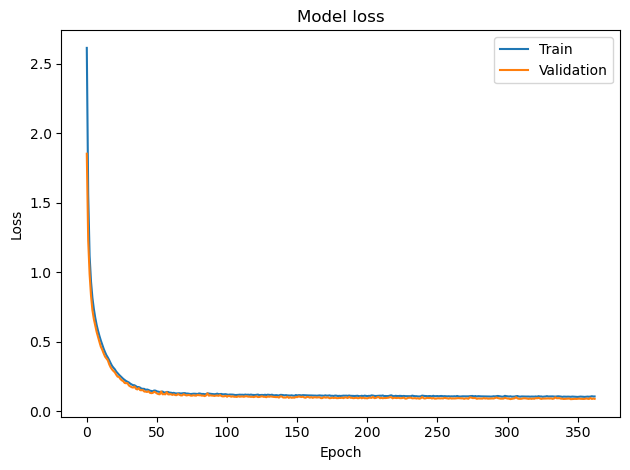

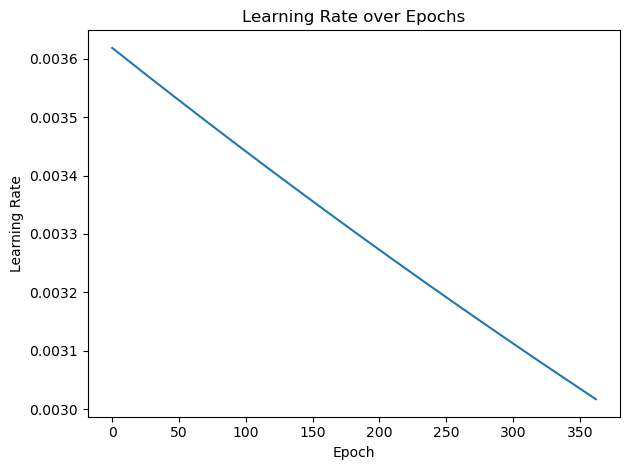

In [39]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER:
        # now both searches should have completed, so lets get the best hyperparams 
        # and retrain with history saved so we can look at it
        best_hp = tuner.get_best_hyperparameters(1)[0]
        
        # make the models again using the best hyperparams
        model = tuner.hypermodel.build(best_hp)

        lr_monitor = LearningRateMonitor()  # make learning rate monitor
        
        value_sw_train = np.asarray(y_exists_train).astype("float32")  # keep (N,16)
        value_sw_train_val   = np.asarray(y_exists_val).astype("float32")    # keep (N,16)
        value_sw_val = np.asarray(y_exists_val).astype("float32")
        
        history = model.fit(
            np.asarray(X_train),
            {
                "value_out": np.asarray(y_value_train),
                "exists_out": np.asarray(y_exists_train),
            },
            sample_weight={
                "value_out": np.asarray(y_exists_train).astype("float32"),           # (N,16) if you’re masking per-dim
                "exists_out": np.ones((len(y_exists_train),), dtype="float32"),      # (N,)
            },
            validation_data=(
                np.asarray(X_val),
                {
                    "value_out": np.asarray(y_value_val),
                    "exists_out": np.asarray(y_exists_val),
                },
                {
                    "value_out": np.asarray(y_exists_val).astype("float32"),
                    "exists_out": np.ones((len(y_exists_val),), dtype="float32"),
                },
            ),
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            callbacks=[early_stopping, lr_monitor],
            verbose=1,
        )


        
        # keep getting a memory allocation error on EAF so lets free everything after the first 
        # model fit, before moving to the next one
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'plots/{encoding}_history.pdf')
    plt.show()

    plt.plot(lr_monitor.learning_rates)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.tight_layout()
    plt.savefig(f'plots/{encoding}_learning_rate.pdf')
    plt.show()
else:
    if KERAS_TUNER:
        # now both searches should have completed, so lets get the best hyperparams 
        # and retrain with history saved so we can look at it
        best_hp_linear = tuner_linear_encoding.get_best_hyperparameters(1)[0]
        
        # make the models again using the best hyperparams
        model_linear = tuner_linear_encoding.hypermodel.build(best_hp_linear)

        lr_monitor_linear_encoding = LearningRateMonitor()  # make learning rate monitor
        
        # retrain with history so we can plot it
        history_linear_encoding = model_linear.fit(
            np.asarray(X_train_linear_encoding),
            {'value_out': np.asarray(y_value_train_linear_encoding), 'exists_out': np.asarray(y_exists_train_linear_encoding)},
            epochs=EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            sample_weight={
                "value_out": np.asarray(y_exists_train_linear_encoding).astype("float32"),
                "exists_out": np.ones((len(y_exists_train_linear_encoding),), dtype="float32"),
            },
            validation_data=(
                np.asarray(X_val_linear_encoding),
                {'value_out': np.asarray(y_value_val_linear_encoding), 'exists_out': np.asarray(y_exists_val_linear_encoding)},
                {
                    "value_out": np.asarray(y_exists_val_linear_encoding).astype("float32"),
                    "exists_out": np.ones((len(y_exists_val_linear_encoding),), dtype="float32"),
                },
            ),

            callbacks=[early_stopping, lr_monitor_linear_encoding],
            verbose=1
        )
        
        # keep getting a memory allocation error on EAF so lets free everything after the first 
        # model fit, before moving to the next one
        
        del model_linear
        tf.keras.backend.clear_session()
        gc.collect()

    plt.plot(history_linear_encoding.history['loss'])
    plt.plot(history_linear_encoding.history['val_loss'])
    plt.title('Model loss linear encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.tight_layout()
    plt.savefig('plots/linear_encoding_history.pdf')
    plt.show()

    plt.plot(lr_monitor_linear_encoding.learning_rates)
    plt.title("Learning Rate over Epochs linear encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.tight_layout()
    plt.savefig('plots/linear_encoding_learning_rate.pdf')
    plt.show()


In [40]:
#I needed to restart the kernal and skip the block above to run this block-otherwise i got memory allocation error. 
#theres probably a better way to do this--like clearing the memory before running this block so you can run both models sequentially

if 'Try Both' in ENCODING_TYPE and KERAS_TUNER:
    best_hp_onehot = tuner_one_hot_encoding.get_best_hyperparameters(1)[0]
    model_onehot = tuner_one_hot_encoding.hypermodel.build(best_hp_onehot)

    lr_monitor_one_hot_encoding = LearningRateMonitor()  # make learning rate monitor
    
    history_one_hot_encoding = model_onehot.fit(
        np.asarray(X_train_one_hot_encoding),
        {'value_out': np.asarray(y_value_train_one_hot_encoding),
         'exists_out': np.asarray(y_exists_train_one_hot_encoding)},
        sample_weight={
            "value_out": np.asarray(y_exists_train_one_hot_encoding).astype("float32"),
            "exists_out": np.ones((len(y_exists_train_one_hot_encoding),), dtype="float32"),
        },
        epochs=EPOCHS,
        batch_size=TRAIN_BATCH_SIZE,
        validation_data=(
            np.asarray(X_val_one_hot_encoding),
            {'value_out': np.asarray(y_value_val_one_hot_encoding),
             'exists_out': np.asarray(y_exists_val_one_hot_encoding)},
            {
                "value_out": np.asarray(y_exists_val_one_hot_encoding).astype("float32"),
                "exists_out": np.ones((len(y_exists_val_one_hot_encoding),), dtype="float32"),
            },
        ),
        callbacks=[early_stopping, lr_monitor_one_hot_encoding],
        verbose=1
    )


    plt.plot(history_one_hot_encoding.history['loss'])
    plt.plot(history_one_hot_encoding.history['val_loss'])
    plt.title('Model loss one hot encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.tight_layout()
    plt.savefig('plots/one_hot_encoding_history.pdf')
    plt.show()
    
    plt.plot(lr_monitor_one_hot_encoding.learning_rates)
    plt.title("Learning Rate over Epochs one hot encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.tight_layout()
    plt.savefig('plots/one_hot_encoding_learning_rate.pdf')
    plt.show()


Measure and print metrics.

In [43]:
#take a look at the loss results and save them 

# clear everything so we start with a blank slate memory wise
tf.keras.backend.clear_session()                         #clear tf backend
gc.collect()                                             #just collect stray things
#tf.config.experimental.reset_memory_stats('GPU:0')       #clear gpus


def get_loss(eval_out):
    # eval_out can be float, list/tuple/ndarray, or dict
    if isinstance(eval_out, dict):
        return float(eval_out.get('loss', list(eval_out.values())[0]))
    if isinstance(eval_out, (list, tuple, np.ndarray)):
        return float(eval_out[0])
    return float(eval_out)

def mlp_signature(m, prefix="mlp"):
    #get the model input sizze first
    in_shape = m.input_shape
    if isinstance(in_shape, list):     #just get the first one
        in_shape = in_shape[0]
    dims = [d for d in in_shape[1:] if d is not None]
    input_size = int(np.prod(dims)) if dims else "None"

    # now get the dense laysers in order
    dense_units = [l.units for l in m.layers if isinstance(l, Dense)]

    parts = [prefix, str(input_size)] + [str(u) for u in dense_units]
    return "_".join(parts)

    
if 'Try Both' not in ENCODING_TYPE:
    model = load_model(best_model_file, compile=False)
    model.compile(
        optimizer='adam',
        loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
        loss_weights={'value_out': 1.0, 'exists_out': 1.0},
        metrics={'value_out': [VALUE_LOSS_FN], 'exists_out': ['accuracy']}
    )


    test_loss_result = model.evaluate(
        np.asarray(X_test),
        {'value_out': np.asarray(y_value_test), 'exists_out': np.asarray(y_exists_test)},
        sample_weight={
            "value_out": np.asarray(y_exists_test).astype("float32"),  # (N,16)
            "exists_out": np.ones((len(y_exists_test),), dtype="float32"),
        },
        verbose=0
    )

    test_loss_result = get_loss(test_loss_result)
    
    #save the shape for the next block so we can save it using the definition above
    model_shape = mlp_signature(model)

    print('Current loss {} encoding {}: {}'.format(encoding, TRAIN_LOSS, test_loss_result))
    
    results_df = pd.DataFrame([
        {'Encoding Type': f'{ENCODING_TYPE} Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result},
        ])

else:
    # we need to do some fancy allocation of recources if we are going to load both models
    # do the first on one GPU
    linear_model = load_model(best_model_file_linear, compile=False)
    linear_model.compile(
        optimizer='adam',
        loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
        loss_weights={'value_out': 1.0, 'exists_out': 1.0}
    )
    test_loss_result_linear_encoding = linear_model.evaluate(
        np.asarray(X_test_linear_encoding),
        {'value_out': np.asarray(y_value_test_linear_encoding), 'exists_out': np.asarray(y_exists_test_linear_encoding)},
        sample_weight={
            "value_out": np.asarray(y_exists_test_linear_encoding).astype("float32"),
            "exists_out": np.ones((len(y_exists_test_linear_encoding),), dtype="float32"),
        },
        verbose=0
    )

    test_loss_result_linear_encoding = get_loss(test_loss_result_linear_encoding)
    
    # now do on CPU to avoid GPU allocation
    with tf.device('/GPU:0'):
        onehot_model = load_model(best_model_file_onehot, compile=False)
        onehot_model.compile(
            optimizer='adam',
            loss={'value_out': VALUE_LOSS_FN, 'exists_out': 'binary_crossentropy'},
            loss_weights={'value_out': 1.0, 'exists_out': 1.0}
        )
        test_loss_result_one_hot_encoding = onehot_model.evaluate(
            np.asarray(X_test_one_hot_encoding),
            {'value_out': np.asarray(y_value_test_one_hot_encoding), 'exists_out': np.asarray(y_exists_test_one_hot_encoding)},
            sample_weight={
            "value_out": np.asarray(y_exists_test_one_hot_encoding).astype("float32"),
            "exists_out": np.ones((len(y_exists_test_one_hot_encoding),), dtype="float32"),
        },
            verbose=0
        )
        test_loss_result_one_hot_encoding = get_loss(test_loss_result_one_hot_encoding)

    #save the shape for the next block so we can save it using the definition above
    model_shape_one_hot_encoding = mlp_signature(onehot_model)
    model_shape_linear_encoding  = mlp_signature(linear_model)
    
    print('Current loss linear encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_linear_encoding))
    print('Current loss one hot encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_one_hot_encoding))
    
    results_df = pd.DataFrame([
        {'Encoding Type': 'linear Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_linear_encoding},
        {'Encoding Type': 'One Hot Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_one_hot_encoding}
    ])

print(results_df.to_string(index=False))
results_df.to_csv('test_loss_results.csv', index=False)


Current loss one_hot encoding mae: 0.09331876039505005
   Encoding Type Train Loss Metric  Test Loss
one hot Encoding               mae   0.093319


## Compare predictions vs. test set

In [44]:
import csv
if 'Try Both' not in ENCODING_TYPE:
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape,
        ENCODING_TYPE,
        test_loss_result,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
    
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df = df.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

else:
    #---------------------------------------------------one hot---------------------------------------
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape_one_hot_encoding,
        'One Hot',
        test_loss_result_one_hot_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
            
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df_one_hot_encoding = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_one_hot_encoding = df_one_hot_encoding.style.apply(color_red_column, subset=['test_loss'])
    #---------------------------------------------------linear---------------------------------------
    csv_data_linear_encoding = [[
        DATA_AUGMENTATION,
        model_shape_linear_encoding,
        'linear',
        test_loss_result_linear_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file_linear_encoding = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    with open(csv_file_linear_encoding, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data_linear_encoding)
    
    # Convert data to DataFrame for easier display
    df_linear_encoding = pd.read_csv(csv_file_linear_encoding)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_linear_encoding = df_linear_encoding.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df_linear_encoding)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

,data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case
0,True,mlp_2_1500_2800_1300_2100_45,One Hot,0.026580,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
1,True,mlp_2_600_100_2600_5000_45,Linear,0.027197,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
2,True,mlp_2_1500_2800_1300_2100_45,one hot,0.026581,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
3,True,mlp_2_3300_200_4600_1700_45,one hot,0.023184,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
4,True,mlp_2_3300_200_4600_1700_45,one hot,0.023925,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
5,True,mlp_2_700_3800_400_1800_16,one hot,0.045630,mean_squared_error,0.400000,50,32,0.15/0.15,0.001456,100,0.990000,False
6,True,mlp_2_700_3800_400_1800_16,one hot,0.041409,mean_squared_error,0.400000,50,32,0.15/0.15,0.002648,100,0.990000,False
7,True,mlp_2_2000_400_1300_1700_16_16,one hot,0.087074,mean_squared_error,0.400000,50,32,0.15/0.15,0.002648,100,0.990000,False
8,True,mlp_2_2000_400_1300_1700_16_16,one hot,0.080590,mean_squared_error,0.400000,50,32,0.15/0.15,0.002505,100,0.990000,False
9,True,mlp_2_2000_2700_500_4000_16_16,one hot,0.086770,mean_squared_error,0.400000,50,32,0.15/0.15,0.002505,100,0.990000,False


In [45]:
# Decide which model file & test set to use
if 'Try Both' not in ENCODING_TYPE:
    chosen_path = best_model_file
    X_test_cur = np.asarray(X_test)
    y_value_test_cur = np.asarray(y_value_test)
    y_exists_test_cur = np.asarray(y_exists_test)
else:
    if test_loss_result_linear_encoding < test_loss_result_one_hot_encoding:
        chosen_path = best_model_file_linear
        X_test_cur = np.asarray(X_test_linear_encoding)
        y_value_test_cur = np.asarray(y_value_test_linear_encoding)
        y_exists_test_cur = np.asarray(y_exists_test_linear_encoding)
        y_encoding_format_name = 'linear'
    else:
        chosen_path = best_model_file_onehot
        X_test_cur = np.asarray(X_test_one_hot_encoding)
        y_value_test_cur = np.asarray(y_value_test_one_hot_encoding)
        y_exists_test_cur = np.asarray(y_exists_test_one_hot_encoding)
        y_encoding_format_name = 'one_hot'

# clear everything again, then load & predict on one cpu device to avoid the memory thing again
tf.keras.backend.clear_session()
gc.collect()

with tf.device('/CPU:0'):
    chosen_model = load_model(chosen_path, compile=False)
    pred = chosen_model.predict(X_test_cur, verbose=0)

# Unpack model outputs into proper numeric arrays
if isinstance(pred, dict):
    y_value_pred = np.asarray(pred['value_out'])
    y_exists_pred = np.asarray(pred['exists_out'])
else:
    y_value_pred, y_exists_pred = pred
    y_value_pred = np.asarray(y_value_pred)
    y_exists_pred = np.asarray(y_exists_pred)


In [46]:
#now lets look at a specfic case to see how the model predicts things
if 'Try Both' not in ENCODING_TYPE:
    y_encoding_format_name = encoding
    
filename = f'y_characteristics_{y_encoding_format_name}_encoding.csv'
with open(filename, 'r') as f:
    headers = f.readline().strip().split(',')

X_test_cur = np.asarray(X_test_cur)
y_value_test_cur = np.asarray(y_value_test_cur)
y_exists_test_cur = np.asarray(y_exists_test_cur)
y_value_pred = np.asarray(y_value_pred)

n_samples, n_params = y_value_test_cur.shape
#change nsamples if you dont want to look at everything
n_samples = 3

# raw errors
sq_errors = (y_value_test_cur - y_value_pred) ** 2
abs_errors = np.abs(y_value_test_cur - y_value_pred)

# mask out parameters that are "not defined" according to the ground-truth exists flag
sq_errors_masked = np.where(y_exists_test_cur == 1.0, sq_errors, np.nan)
abs_errors_masked = np.where(y_exists_test_cur == 1.0, abs_errors, np.nan)

# make a nice dataframe so the output is comprehensible
rows = []
for i in range(n_samples):
    cav_freq, kappa = X_test_cur[i, 0], X_test_cur[i, 1]
    for j in range(n_params):
        rows.append({
            "sample_idx": i,
            "cavity_frequency": cav_freq,
            "kappa": kappa,
            "param": headers[j],
            "exists": y_exists_test_cur[i, j],
            "ref": y_value_test_cur[i, j],
            "pred": y_value_pred[i, j],
            "abs_error": abs_errors_masked[i, j],
            "sq_error": sq_errors_masked[i, j],
        })

df = pd.DataFrame(rows)

#save it incase we want to do stuff with this in the future
out_csv = Path(f"predictions_and_errors_{y_encoding_format_name}.csv")
df.to_csv(out_csv, index=False, float_format="%.6g")
print(f"\nSaved CSV -> {out_csv.resolve()}\n")

# print it out nicely 
for i in range(n_samples):
    sub = df[df["sample_idx"] == i].copy()
    sub = sub[["param", "exists", "ref", "pred", "abs_error", "sq_error"]]
    header_line = (
        f"— Sample {i} — "
        f"X: cavity_frequency={X_test_cur[i,0]:.6g}, kappa={X_test_cur[i,1]:.6g}"
    )
    print(header_line)
    print(sub.to_string(index=False))
    print() 

# (Optional) quick global stats (only over defined parameters)
print("Global error stats (defined parameters only):")
print("  min abs_error:", float(np.nanmin(abs_errors_masked)))
print("  median abs_error:", float(np.nanmedian(abs_errors_masked)))
print("  max abs_error:", float(np.nanmax(abs_errors_masked)))

''' 
Here onehot/linear encoding and the mlp which maps categorical data to 1s and 0s is probably 
throwing off the global average. These will be rounded in the future and will probably always 
round to the right number to reconstruct the correct category-- but for now it might throw off 
the overall average error. In the future we might want to just have it consider the non categorical 
data when finding an overall average and reporting that number.
'''



Saved CSV -> /home/olivias/ML_qubit_design/model_predict_cavity_claw_RouteMeander_eigenmode/predictions_and_errors_one_hot.csv

— Sample 0 — X: cavity_frequency=0.0208384, kappa=0.16982
                                                          param  exists      ref      pred  abs_error     sq_error
   design_options.claw_opts.connection_pads.readout.claw_length     1.0 0.403941  0.409193   0.005252 2.758260e-05
design_options.claw_opts.connection_pads.readout.ground_spacing     1.0 0.000000 -0.002957   0.002957 8.742485e-06
                                 design_options.claw_opts.pos_x     1.0 0.000000 -0.005582   0.005582 3.115487e-05
                          design_options.claw_opts.cross_length     1.0 0.000000  0.002558   0.002558 6.544872e-06
                           design_options.claw_opts.cross_width     1.0 0.000000 -0.000420   0.000420 1.762846e-07
                             design_options.claw_opts.cross_gap     1.0 0.000000 -0.000630   0.000630 3.969078e-07
        

' \nHere onehot/linear encoding and the mlp which maps categorical data to 1s and 0s is probably \nthrowing off the global average. These will be rounded in the future and will probably always \nround to the right number to reconstruct the correct category-- but for now it might throw off \nthe overall average error. In the future we might want to just have it consider the non categorical \ndata when finding an overall average and reporting that number.\n'

### Unscaled test vs predictions

In [47]:
#unscale everything and look at errors again. 
#You can compare the unscaled actual values to the ml_00...py notebook to convice yourself that unscaling worked

with open('X_names', 'r') as f:
    X_index_names = f.read().splitlines()

# unscaling x
X_test_unscaled = np.asarray(X_test_cur.copy())
for i in range(X_test_unscaled.shape[0]):
    for j in range(X_test_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_X_{X_index_names[j]}.save')
        X_test_unscaled[i, j] = scaler.inverse_transform([[X_test_unscaled[i, j]]])[0][0]

# unscaling y (value head only)
y_value_test_unscaled = np.asarray(y_value_test_cur.copy())
for i in range(y_value_test_unscaled.shape[0]):
    for j in range(y_value_test_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_y_value__{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_value_test_unscaled[i, j] = scaler.inverse_transform([[y_value_test_unscaled[i, j]]])[0][0]

# unscaling y predictions (value head only)
y_value_pred_unscaled = np.asarray(y_value_pred.copy())
for i in range(y_value_pred_unscaled.shape[0]):
    for j in range(y_value_pred_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_y_value__{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_value_pred_unscaled[i, j] = scaler.inverse_transform([[y_value_pred_unscaled[i, j]]])[0][0]

n_samples, n_params = y_value_test_unscaled.shape
n_samples = 3 

# find how good or bad we did (the errors)
sq_errors_unscaled = (y_value_test_unscaled - y_value_pred_unscaled) ** 2
abs_errors_unscaled = np.abs(y_value_test_unscaled - y_value_pred_unscaled)

# mask out parameters that are not defined according to ground-truth exists flag
sq_errors_unscaled_masked = np.where(y_exists_test_cur == 1.0, sq_errors_unscaled, np.nan)
abs_errors_unscaled_masked = np.where(y_exists_test_cur == 1.0, abs_errors_unscaled, np.nan)

# making a nice fancy dataframe, we like fancy things
rows_unscaled = []
for i in range(n_samples):
    cav_freq, kappa = X_test_unscaled[i, 0], X_test_unscaled[i, 1]
    for j in range(n_params):
        rows_unscaled.append({
            "sample_idx": i,
            "cavity_frequency": cav_freq,
            "kappa": kappa,
            "param": headers[j],
            "exists": y_exists_test_cur[i, j],
            "ref_unscaled": y_value_test_unscaled[i, j],
            "pred_unscaled": y_value_pred_unscaled[i, j],
            "abs_error_unscaled": abs_errors_unscaled_masked[i, j],
            "sq_error_unscaled": sq_errors_unscaled_masked[i, j],
        })

df_unscaled = pd.DataFrame(rows_unscaled)

# save csv of unscaled results uncase we lose this notebook due to github blowing up, ya never know
out_csv_unscaled = Path(f"predictions_and_errors_unscaled_{y_encoding_format_name}.csv")
df_unscaled.to_csv(out_csv_unscaled, index=False, float_format="%.6g")
print(f"\nSaved CSV -> {out_csv_unscaled.resolve()}\n")

# print out stuff so you can see it here if you are to lazy like me to open a csv
for i in range(n_samples):
    sub = df_unscaled[df_unscaled["sample_idx"] == i].copy()
    sub = sub[["param", "exists", "ref_unscaled", "pred_unscaled", "abs_error_unscaled", "sq_error_unscaled"]]
    header_line = (
        f"— Sample {i} (Unscaled) — "
        f"X: cavity_frequency={X_test_unscaled[i,0]:.6g}, kappa={X_test_unscaled[i,1]:.6g}"
    )
    print(header_line)
    print(sub.to_string(index=False))
    print()

# look at overall stats, see below comment for a caviat 
print("Global unscaled error stats (defined parameters only):")
print("  min abs_error:", float(np.nanmin(abs_errors_unscaled_masked)))
print("  median abs_error:", float(np.nanmedian(abs_errors_unscaled_masked)))
print("  max abs_error:", float(np.nanmax(abs_errors_unscaled_masked)))

'''
Here onehot/linear encoding and the MLP which maps categorical data to 1s and 0s is probably 
throwing off the global average. These will be rounded in the future and will probably always 
round to the right number to reconstruct the correct category-- but for now it might throw off 
the overall average error. In the future we might want to just have it consider the non-categorical 
data when finding an overall average and reporting that number.
'''



Saved CSV -> /home/olivias/ML_qubit_design/model_predict_cavity_claw_RouteMeander_eigenmode/predictions_and_errors_unscaled_one_hot.csv

— Sample 0 (Unscaled) — X: cavity_frequency=5.24699e+09, kappa=168252
                                                          param  exists  ref_unscaled  pred_unscaled  abs_error_unscaled  sq_error_unscaled
   design_options.claw_opts.connection_pads.readout.claw_length     1.0      0.000275   2.776654e-04        2.665356e-06       7.104125e-12
design_options.claw_opts.connection_pads.readout.ground_spacing     1.0      0.000004   4.082555e-06        1.744472e-08       3.043183e-16
                                 design_options.claw_opts.pos_x     1.0     -0.001500  -1.502791e-03        2.790838e-06       7.788774e-12
                          design_options.claw_opts.cross_length     1.0      0.000000   6.139907e-07        6.139907e-07       3.769846e-13
                           design_options.claw_opts.cross_width     1.0      0.000000  -1.25

'\nHere onehot/linear encoding and the MLP which maps categorical data to 1s and 0s is probably \nthrowing off the global average. These will be rounded in the future and will probably always \nround to the right number to reconstruct the correct category-- but for now it might throw off \nthe overall average error. In the future we might want to just have it consider the non-categorical \ndata when finding an overall average and reporting that number.\n'